In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('processed_data/merged_df_net_sc.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12280 entries, 0 to 12279
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gross_fu                        12280 non-null  int64  
 1   gross_sc                        12280 non-null  int64  
 2   net_fu                          12280 non-null  float64
 3   net_sc                          12280 non-null  float64
 4   time_first_sc_to_first_net_fu   12280 non-null  float64
 5   electricitybill                 12280 non-null  float64
 6   heatingbill                     12280 non-null  float64
 7   grosscontractsigned             12280 non-null  float64
 8   selfipa_done                    12280 non-null  int64  
 9   zipregion_missing               12280 non-null  int64  
 10  evaluationtime_missing          12280 non-null  int64  
 11  desiredinstallationend_missing  12280 non-null  int64  
 12  electricitybill_missing         

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class TwoStageContractPredictor:
    """
    A two-stage model to predict contract signing while handling temporal leakage
    and class imbalance.
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.stage1_model = None
        self.stage2_model = None
        self.stage1_scaler = StandardScaler()
        self.stage2_scaler = StandardScaler()
        self.stage1_features = None
        self.stage2_features = None

    def identify_feature_stages(self, df):
        # lowercase dataframe columns
        df.columns = df.columns.str.lower()

        stage1_features = [
            'electricitybill', 'heatingbill',
            'selfipa_done', 'zipregion_missing',
            'evaluationtime_missing', 'desiredinstallationend_missing',
            'electricitybill_missing', 'heatingbill_missing',
            'mktgparamscore_missing', 'desiredinstallationend_encoded',
            'mktg_high', 'mktg_low', 'mktg_medium',
            'region_high_performer', 'region_large_good',
            'region_medium', 'region_other',
            'total_bc_attempts', 'total_bc_outcomes',
            'lead_to_first_bc_days', 'bc_duration_days',
            'bc_frequency', 'positive_outcomes_count',
            'negative_outcomes_count', 'noshow_outcomes_count',
            'positive_outcome_ratio', 'negative_outcome_ratio',
            'noshow_outcome_ratio', 'reachability_score',
            'outcome_trend', 'persistence_after_negative',
            'engagement_score', 'efficiency_score',
            'last_bc_outcome_encoded', 'first_bc_outcome_encoded'
        ]

        stage2_features = stage1_features + [
            'gross_fu', 'gross_sc', 'net_fu', 'net_sc',
            'time_first_sc_to_first_net_fu'
        ]

        self.stage1_features = [f for f in stage1_features if f in df.columns]
        self.stage2_features = [f for f in stage2_features if f in df.columns]
        return self.stage1_features, self.stage2_features

    def create_stage_labels(self, df):
        df.columns = df.columns.str.lower()
        stage1_label = (df['net_sc'] > 0).astype(int) if 'net_sc' in df.columns else pd.Series(0, index=df.index)
        stage2_label = df['grosscontractsigned']  # already lowercase in your dataset
        return stage1_label, stage2_label

    def build_neural_network(self, input_dim, name="model"):
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(1, activation='sigmoid')
        ], name=name)
        return model

    def handle_imbalance(self, X, y, strategy='hybrid'):
        if strategy == 'smote':
            smote = SMOTE(random_state=self.random_state)
            X_res, y_res = smote.fit_resample(X, y)
        elif strategy == 'undersample':
            rus = RandomUnderSampler(random_state=self.random_state)
            X_res, y_res = rus.fit_resample(X, y)
        elif strategy == 'hybrid':
            unique, counts = np.unique(y, return_counts=True)
            if len(counts) < 2:
                X_res, y_res = X, y
            else:
                minority_count = min(counts)
                majority_count = max(counts)
                current_ratio = minority_count / majority_count
                smote_ratio = min(0.3, current_ratio * 3)
                final_ratio = min(0.6, current_ratio * 5)
                try:
                    pipeline = ImbPipeline([
                        ('smote', SMOTE(sampling_strategy=smote_ratio, random_state=self.random_state)),
                        ('undersample', RandomUnderSampler(sampling_strategy=final_ratio, random_state=self.random_state))
                    ])
                    X_res, y_res = pipeline.fit_resample(X, y)
                except ValueError:
                    smote = SMOTE(sampling_strategy=min(0.3, current_ratio * 2), random_state=self.random_state)
                    X_res, y_res = smote.fit_resample(X, y)
            return X_res, y_res
        return X, y

    def train_stage1(self, X_train, y_train, X_val, y_val, epochs=50):
        print("Training Stage 1...")
        X_train_scaled = self.stage1_scaler.fit_transform(X_train)
        X_val_scaled = self.stage1_scaler.transform(X_val)
        self.stage1_model = self.build_neural_network(X_train_scaled.shape[1], name="stage1")
        class_weight = {0: 1., 1: 3.}
        self.stage1_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
        self.stage1_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs, batch_size=32,
            class_weight=class_weight,
            callbacks=[early_stop], verbose=0
        )

    def train_stage2(self, X_train, y_train, X_val, y_val, epochs=50):
        print("Training Stage 2...")
        X_train_scaled = self.stage2_scaler.fit_transform(X_train)
        X_val_scaled = self.stage2_scaler.transform(X_val)
        self.stage2_model = self.build_neural_network(X_train_scaled.shape[1], name="stage2")
        self.stage2_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
        self.stage2_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs, batch_size=32,
            callbacks=[early_stop], verbose=0
        )

    def fit(self, df, epochs_stage1=50, epochs_stage2=50):
        self.identify_feature_stages(df)
        stage1_label, stage2_label = self.create_stage_labels(df)

        # --- Stage 1 ---
        X_stage1 = df[self.stage1_features]
        X1_train, X1_val, y1_train, y1_val = train_test_split(
            X_stage1, stage1_label, test_size=0.2,
            random_state=self.random_state, stratify=stage1_label
        )
        self.train_stage1(X1_train, y1_train, X1_val, y1_val, epochs_stage1)

        # --- Stage 2 ---
        stage2_mask = stage1_label == 1
        X_stage2_filtered = df.loc[stage2_mask, self.stage2_features]
        y_stage2_filtered = stage2_label[stage2_mask]

        if len(X_stage2_filtered) == 0 or y_stage2_filtered.nunique() < 2:
            print("\n⚠️ Skipping Stage 2 training (no SC leads or only one class).")
            self.stage2_model = None
            return

        X2_train, X2_val, y2_train, y2_val = train_test_split(
            X_stage2_filtered, y_stage2_filtered, test_size=0.2,
            random_state=self.random_state, stratify=y_stage2_filtered
        )
        self.train_stage2(X2_train, y2_train, X2_val, y2_val, epochs_stage2)

    def predict_proba(self, df):
        X_stage1_scaled = self.stage1_scaler.transform(df[self.stage1_features])
        p_sc = self.stage1_model.predict(X_stage1_scaled).ravel()

        if self.stage2_model is None:
            return {
                'p_sc': p_sc,
                'p_contract_given_sc': np.zeros_like(p_sc),
                'p_contract': p_sc  # fallback
            }

        X_stage2_scaled = self.stage2_scaler.transform(df[self.stage2_features])
        p_contract_given_sc = self.stage2_model.predict(X_stage2_scaled).ravel()
        p_contract = p_sc * p_contract_given_sc

        return {
            'p_sc': p_sc,
            'p_contract_given_sc': p_contract_given_sc,
            'p_contract': p_contract
        }

    def evaluate(self, df):
        predictions = self.predict_proba(df)
        y_true = df['grosscontractsigned']
        auc_score = roc_auc_score(y_true, predictions['p_contract'])
        precision, recall, _ = precision_recall_curve(y_true, predictions['p_contract'])
        pr_auc = auc(recall, precision)
        print("\n=== Model Evaluation ===")
        print(f"ROC-AUC: {auc_score:.4f}")
        print(f"PR-AUC: {pr_auc:.4f}")
        return {'roc_auc': auc_score, 'pr_auc': pr_auc, 'predictions': predictions}


def main(df):
    model = TwoStageContractPredictor(random_state=42)
    model.fit(df, epochs_stage1=50, epochs_stage2=50)
    results = model.evaluate(df)
    predictions = model.predict_proba(df)
    df['pred_sc_probability'] = predictions['p_sc']
    df['pred_contract_given_sc'] = predictions['p_contract_given_sc']
    df['pred_contract_probability'] = predictions['p_contract']
    return model, df, results


In [23]:
model, df_with_predictions, evaluation_results = main(df)

Training Stage 1...
Training Stage 2...
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

=== Model Evaluation ===
ROC-AUC: 0.8633
PR-AUC: 0.6893
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12280 entries, 0 to 12279
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gross_fu                        12280 non-null  int64  
 1   gross_sc                        12280 non-null  int64  
 2   net_fu                          12280 non-null  float64
 3   net_sc                          12280 non-null  float64
 4   time_first_sc_to_first_net_fu   12280 non-null  float64
 5   electricitybill                 12280 non-null  float64
 6   heatingbill                     12280 non-null  float64
 7   grosscontractsigned             12280 non-null  float64
 8   selfipa_done                    12280 non-null  int64  
 9   zipregion_missing               12280 non-null  int64  
 10  evaluationtime_missing          12280 non-null  int64  
 11  desiredinstallationend_missing  12280 non-null  int64  
 12  electricitybill_missing         

comparing different models, after sc only

Dataset shape: (12280, 43)
Target distribution: grosscontractsigned
0.0    10109
1.0     2171
Name: count, dtype: int64
Imbalance ratio: 4.7:1
Train set: 9824 samples
Test set: 2456 samples
Train target distribution: grosscontractsigned
0.0    8087
1.0    1737
Name: count, dtype: int64
Test target distribution: grosscontractsigned
0.0    2022
1.0     434
Name: count, dtype: int64

RANDOM FOREST
Random Forest Results:
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      2022
         1.0       0.78      0.48      0.60       434

    accuracy                           0.88      2456
   macro avg       0.84      0.73      0.76      2456
weighted avg       0.88      0.88      0.87      2456

ROC-AUC: 0.8666
PR-AUC: 0.7055

XGBOOST
XGBoost Results:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      2022
         1.0       0.83      0.56      0.66       434

    accuracy                   

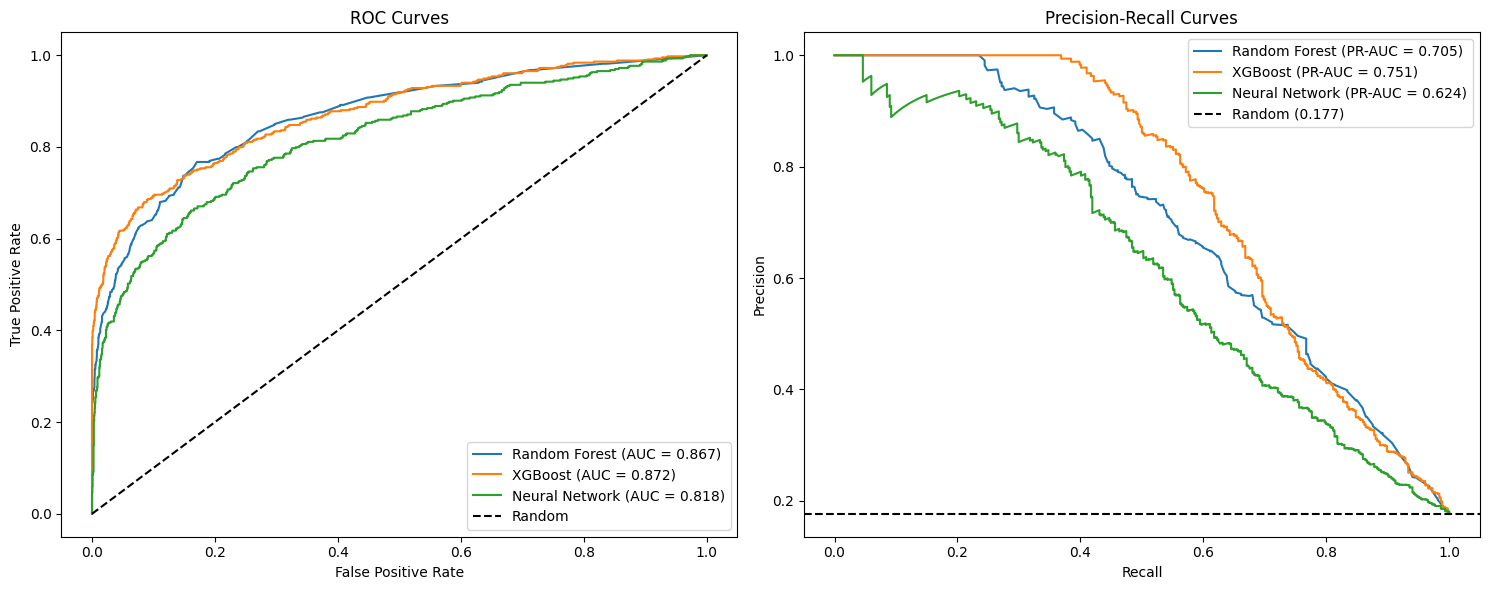


FEATURE IMPORTANCE (Random Forest)
                          feature  importance
41         pred_contract_given_sc    0.205395
42      pred_contract_probability    0.191152
4   time_first_sc_to_first_net_fu    0.086869
40            pred_sc_probability    0.057411
5                 electricitybill    0.043052
2                          net_fu    0.034532
0                        gross_fu    0.033122
24          lead_to_first_bc_days    0.032662
26                   bc_frequency    0.031982
36               engagement_score    0.025167

FEATURE IMPORTANCE (XGBoost)
                           feature  importance
42       pred_contract_probability    0.216809
41          pred_contract_given_sc    0.080808
3                           net_sc    0.040832
4    time_first_sc_to_first_net_fu    0.035707
37                efficiency_score    0.033100
9           evaluationtime_missing    0.032329
24           lead_to_first_bc_days    0.025496
2                           net_fu    0.024999
10  d

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'df' and target is 'grosscontractsigend'
# Separate features and target
X = df.drop('grosscontractsigned', axis=1)
y = df['grosscontractsigned']



print(f"Dataset shape: {X.shape}")
print(f"Target distribution: {y.value_counts()}")
print(f"Imbalance ratio: {y.value_counts()[0]/y.value_counts()[1]:.1f}:1")

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train target distribution: {y_train.value_counts()}")
print(f"Test target distribution: {y_test.value_counts()}")

# Scale features for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================================================
# 1. RANDOM FOREST
# =============================================================================
print("\n" + "="*50)
print("RANDOM FOREST")
print("="*50)

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_pred_proba = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print(classification_report(y_test, rf_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, rf_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, rf_pred_proba):.4f}")

# =============================================================================
# 2. XGBOOST
# =============================================================================
print("\n" + "="*50)
print("XGBOOST")
print("="*50)

xgb_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Results:")
print(classification_report(y_test, xgb_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, xgb_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, xgb_pred_proba):.4f}")

# =============================================================================
# 3. NEURAL NETWORK
# =============================================================================
print("\n" + "="*50)
print("NEURAL NETWORK")
print("="*50)

# Build feedforward network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

nn_pred_proba = nn_model.predict(X_test_scaled).flatten()
nn_pred = (nn_pred_proba > 0.5).astype(int)

print("Neural Network Results:")
print(classification_report(y_test, nn_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, nn_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, nn_pred_proba):.4f}")

# =============================================================================
# COMPARISON SUMMARY
# =============================================================================
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

models = ['Random Forest', 'XGBoost', 'Neural Network']
roc_aucs = [
    roc_auc_score(y_test, rf_pred_proba),
    roc_auc_score(y_test, xgb_pred_proba),
    roc_auc_score(y_test, nn_pred_proba)
]
pr_aucs = [
    average_precision_score(y_test, rf_pred_proba),
    average_precision_score(y_test, xgb_pred_proba),
    average_precision_score(y_test, nn_pred_proba)
]

comparison_df = pd.DataFrame({
    'Model': models,
    'ROC-AUC': roc_aucs,
    'PR-AUC': pr_aucs
})

print(comparison_df.round(4))

# =============================================================================
# VISUALIZATION
# =============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_pred_proba)

ax1.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_aucs[0]:.3f})')
ax1.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_aucs[1]:.3f})')
ax1.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_aucs[2]:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()

# Precision-Recall Curves
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_pred_proba)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_pred_proba)
precision_nn, recall_nn, _ = precision_recall_curve(y_test, nn_pred_proba)

ax2.plot(recall_rf, precision_rf, label=f'Random Forest (PR-AUC = {pr_aucs[0]:.3f})')
ax2.plot(recall_xgb, precision_xgb, label=f'XGBoost (PR-AUC = {pr_aucs[1]:.3f})')
ax2.plot(recall_nn, precision_nn, label=f'Neural Network (PR-AUC = {pr_aucs[2]:.3f})')
ax2.axhline(y=y_test.mean(), color='k', linestyle='--', label=f'Random ({y_test.mean():.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()

plt.tight_layout()
plt.show()

# Feature importance for tree-based models
print("\n" + "="*30)
print("FEATURE IMPORTANCE (Random Forest)")
print("="*30)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

print("\n" + "="*30)
print("FEATURE IMPORTANCE (XGBoost)")
print("="*30)
feature_importance_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_xgb.head(10))

Deeper on two layer model

In [5]:
# now our dataaset is merged_df that has aòso peolpe who havent made it to net sc
df2= pd.read_csv("processed_data/merged_df_only_after_march.csv")

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score



class TwoStageContractPredictor:
    """
    Two-stage funnel model:
    Stage 1: Predict probability of reaching SC
    Stage 2: Predict probability of signing given SC
    Final probability = p_sc * p_contract_given_sc
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.stage1_model = None
        self.stage2_model = None
        self.stage1_scaler = StandardScaler()
        self.stage2_scaler = StandardScaler()
        self.stage1_features = None
        self.stage2_features = None

    def identify_feature_stages(self, df):
        """Define features by stage (case-insensitive)."""
        df.columns = df.columns.str.lower()

        stage1_features = [
            # Lead-level features (pre-SC)
            'electricitybill', 'heatingbill',
            'selfipa_done', 'zipregion_missing',
            'evaluationtime_missing', 'desiredinstallationend_missing',
            'electricitybill_missing', 'heatingbill_missing',
            'mktgparamscore_missing', 'desiredinstallationend_encoded',
            'mktg_high', 'mktg_low', 'mktg_medium',
            'region_high_performer', 'region_large_good',
            'region_medium', 'region_other',
            'total_bc_attempts', 'total_bc_outcomes',
            'lead_to_first_bc_days', 'bc_duration_days',
            'bc_frequency', 'positive_outcomes_count',
            'negative_outcomes_count', 'noshow_outcomes_count',
            'positive_outcome_ratio', 'negative_outcome_ratio',
            'noshow_outcome_ratio', 'reachability_score',
            'outcome_trend', 'persistence_after_negative',
            'engagement_score', 'efficiency_score',
            'last_bc_outcome_encoded', 'first_bc_outcome_encoded'
        ]

        stage2_features = stage1_features + [
            # SC-related features (available only post-SC)
            'gross_fu', 'gross_sc', 'net_fu', 'net_sc',
            'time_first_sc_to_first_net_fu'
        ]

        self.stage1_features = [f for f in stage1_features if f in df.columns]
        self.stage2_features = [f for f in stage2_features if f in df.columns]

        print("Stage 1 features used:", self.stage1_features)
        print("Stage 2 features used:", self.stage2_features)

        return self.stage1_features, self.stage2_features

    def create_stage_labels(self, df):
        """Create labels for each stage."""
        df.columns = df.columns.str.lower()
        stage1_label = (df['net_sc'] > 0).astype(int) if 'net_sc' in df.columns else pd.Series(0, index=df.index)
        stage2_label = df['grosscontractsigned']
        return stage1_label, stage2_label

    def build_neural_network(self, input_dim, name="model"):
        """Simple dense NN."""
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(1, activation='sigmoid')
        ], name=name)
        return model

    def train_stage1(self, X_train, y_train, X_val, y_val, epochs=50):
        print("\nTraining Stage 1 (Predicting SC)...")
        X_train_scaled = self.stage1_scaler.fit_transform(X_train)
        X_val_scaled = self.stage1_scaler.transform(X_val)
        self.stage1_model = self.build_neural_network(X_train_scaled.shape[1], name="stage1")
        class_weight = {0: 1., 1: 3.}  # weight SC positives more
        self.stage1_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
        self.stage1_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs, batch_size=32,
            class_weight=class_weight,
            callbacks=[early_stop], verbose=0
        )

    def train_stage2(self, X_train, y_train, X_val, y_val, epochs=50):
        print("\nTraining Stage 2 (Predicting Contract given SC)...")
        X_train_scaled = self.stage2_scaler.fit_transform(X_train)
        X_val_scaled = self.stage2_scaler.transform(X_val)
        self.stage2_model = self.build_neural_network(X_train_scaled.shape[1], name="stage2")
        self.stage2_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
        self.stage2_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs, batch_size=32,
            callbacks=[early_stop], verbose=0
        )

    def fit(self, df, epochs_stage1=50, epochs_stage2=50):
        """Train the two-stage funnel model."""
        self.identify_feature_stages(df)
        stage1_label, stage2_label = self.create_stage_labels(df)

        # --- Stage 1 ---
        X_stage1 = df[self.stage1_features]
        X1_train, X1_val, y1_train, y1_val = train_test_split(
            X_stage1, stage1_label, test_size=0.2,
            random_state=self.random_state, stratify=stage1_label
        )
        self.train_stage1(X1_train, y1_train, X1_val, y1_val, epochs_stage1)

        # --- Stage 2 ---
        stage2_mask = stage1_label == 1
        X_stage2_filtered = df.loc[stage2_mask, self.stage2_features]
        y_stage2_filtered = stage2_label[stage2_mask]

        if len(X_stage2_filtered) == 0 or y_stage2_filtered.nunique() < 2:
            print("\n⚠️ Skipping Stage 2 (no SC leads or only one class).")
            self.stage2_model = None
            return

        X2_train, X2_val, y2_train, y2_val = train_test_split(
            X_stage2_filtered, y_stage2_filtered, test_size=0.2,
            random_state=self.random_state, stratify=y_stage2_filtered
        )
        self.train_stage2(X2_train, y2_train, X2_val, y2_val, epochs_stage2)

    def predict_proba(self, df):
        """Generate probabilities for SC, contract given SC, and overall."""
        df = df.copy()
        df.columns = df.columns.str.lower()

        # Stage 1
        X_stage1_scaled = self.stage1_scaler.transform(df[self.stage1_features])
        p_sc = self.stage1_model.predict(X_stage1_scaled).ravel()

        # Stage 2
        if self.stage2_model is None:
            return {'p_sc': p_sc,
                    'p_contract_given_sc': np.zeros_like(p_sc),
                    'p_contract': p_sc}  # fallback

        X_stage2_scaled = self.stage2_scaler.transform(df[self.stage2_features])
        p_contract_given_sc = self.stage2_model.predict(X_stage2_scaled).ravel()
        p_contract = p_sc * p_contract_given_sc

        return {'p_sc': p_sc,
                'p_contract_given_sc': p_contract_given_sc,
                'p_contract': p_contract}

    def evaluate(self, df):
        """Evaluate full model performance."""
        predictions = self.predict_proba(df)
        y_true = df['grosscontractsigned']
        auc_score = roc_auc_score(y_true, predictions['p_contract'])
        precision, recall, _ = precision_recall_curve(y_true, predictions['p_contract'])
        pr_auc = auc(recall, precision)
        print("\n=== Model Evaluation ===")
        print(f"ROC-AUC: {auc_score:.4f}")
        print(f"PR-AUC: {pr_auc:.4f}")
        return {'roc_auc': auc_score, 'pr_auc': pr_auc, 'predictions': predictions}


def main(df):
    model = TwoStageContractPredictor(random_state=42)
    model.fit(df, epochs_stage1=50, epochs_stage2=50)
    results = model.evaluate(df)
    predictions = model.predict_proba(df)
    df['pred_sc_probability'] = predictions['p_sc']
    df['pred_contract_given_sc'] = predictions['p_contract_given_sc']
    df['pred_contract_probability'] = predictions['p_contract']
    return model, df, results

def evaluate_stage2_only(df_with_predictions):
    """Evaluate Stage 2 (conversion given SC) separately."""
    mask = df_with_predictions['net_sc'] > 0
    y_true_sc = df_with_predictions.loc[mask, 'grosscontractsigned']
    y_pred_sc = df_with_predictions.loc[mask, 'pred_contract_given_sc']

    if len(y_true_sc) == 0 or y_true_sc.nunique() < 2:
        print("⚠️ No valid SC leads for Stage 2 evaluation.")
        return None

    # ROC-AUC
    roc_auc_sc = roc_auc_score(y_true_sc, y_pred_sc)

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_true_sc, y_pred_sc)
    pr_auc_sc = auc(recall, precision)

    print("\n=== Stage 2 Evaluation (only SC leads) ===")
    print(f"ROC-AUC (Stage 2): {roc_auc_sc:.4f}")
    print(f"PR-AUC  (Stage 2): {pr_auc_sc:.4f}")

    return {"roc_auc_stage2": roc_auc_sc, "pr_auc_stage2": pr_auc_sc}


In [7]:
model, df_with_predictions, evaluation_results = main(df2)

Stage 1 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg_low', 'mktg_medium', 'region_high_performer', 'region_medium', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score', 'last_bc_outcome_encoded', 'first_bc_outcome_encoded']
Stage 2 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg

In [11]:
model, df_with_predictions, evaluation_results = main(df2)
stage2_eval = evaluate_stage2_only(df_with_predictions)


Stage 1 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg_low', 'mktg_medium', 'region_high_performer', 'region_medium', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score', 'last_bc_outcome_encoded', 'first_bc_outcome_encoded']
Stage 2 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg

In [12]:
precision, recall, thresholds = precision_recall_curve(y_true_sc, y_pred_sc)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1)
print("Best threshold:", thresholds[best_idx])
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])


Best threshold: 0.19760677
Precision: 0.33226837060702874
Recall: 0.3525423728813559


🔥 Full Two-Stage Funnel Model (with switchable Stage 2)

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb


class TwoStageContractPredictorFlexible:
    """
    Two-stage funnel model with flexible Stage 2 backend (NN or XGBoost).
    Stage 1: Predict SC probability
    Stage 2: Predict contract probability given SC
    Final probability = p_sc * p_contract_given_sc
    """

    def __init__(self, stage2_type="nn", random_state=42):
        self.random_state = random_state
        self.stage2_type = stage2_type  # "nn" or "xgb"
        self.stage1_model = None
        self.stage2_model = None
        self.stage1_scaler = StandardScaler()
        self.stage2_scaler = StandardScaler() if stage2_type == "nn" else None
        self.stage1_features = None
        self.stage2_features = None

    def identify_feature_stages(self, df):
        df.columns = df.columns.str.lower()

        stage1_features = [
            'electricitybill', 'heatingbill',
            'selfipa_done', 'zipregion_missing',
            'evaluationtime_missing', 'desiredinstallationend_missing',
            'electricitybill_missing', 'heatingbill_missing',
            'mktgparamscore_missing', 'desiredinstallationend_encoded',
            'mktg_high', 'mktg_low', 'mktg_medium',
            'region_high_performer', 'region_large_good',
            'region_medium', 'region_other',
            'total_bc_attempts', 'total_bc_outcomes',
            'lead_to_first_bc_days', 'bc_duration_days',
            'bc_frequency', 'positive_outcomes_count',
            'negative_outcomes_count', 'noshow_outcomes_count',
            'positive_outcome_ratio', 'negative_outcome_ratio',
            'noshow_outcome_ratio', 'reachability_score',
            'outcome_trend', 'persistence_after_negative',
            'engagement_score', 'efficiency_score',
            'last_bc_outcome_encoded', 'first_bc_outcome_encoded'
        ]

        stage2_features = stage1_features + [
            'gross_fu', 'gross_sc', 'net_fu', 'net_sc',
            'time_first_sc_to_first_net_fu'
        ]

        self.stage1_features = [f for f in stage1_features if f in df.columns]
        self.stage2_features = [f for f in stage2_features if f in df.columns]

        print("Stage 1 features used:", self.stage1_features)
        print("Stage 2 features used:", self.stage2_features)

    def create_stage_labels(self, df):
        df.columns = df.columns.str.lower()
        stage1_label = (df['net_sc'] > 0).astype(int) if 'net_sc' in df.columns else pd.Series(0, index=df.index)
        stage2_label = df['grosscontractsigned']
        return stage1_label, stage2_label

    def build_neural_network(self, input_dim, name="model"):
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(1, activation='sigmoid')
        ], name=name)
        return model

    def train_stage1(self, X_train, y_train, X_val, y_val, epochs=50):
        print("\nTraining Stage 1 (Predicting SC)...")
        X_train_scaled = self.stage1_scaler.fit_transform(X_train)
        X_val_scaled = self.stage1_scaler.transform(X_val)
        self.stage1_model = self.build_neural_network(X_train_scaled.shape[1], name="stage1")
        class_weight = {0: 1., 1: 3.}
        self.stage1_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
        self.stage1_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs, batch_size=32,
            class_weight=class_weight,
            callbacks=[early_stop], verbose=0
        )

    def train_stage2(self, X_train, y_train, X_val, y_val, epochs=50):
        print(f"\nTraining Stage 2 (Predicting Contract given SC) using {self.stage2_type.upper()}...")
        if self.stage2_type == "nn":
            X_train_scaled = self.stage2_scaler.fit_transform(X_train)
            X_val_scaled = self.stage2_scaler.transform(X_val)
            self.stage2_model = self.build_neural_network(X_train_scaled.shape[1], name="stage2")
            self.stage2_model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', keras.metrics.AUC(name='auc')]
            )
            early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
            self.stage2_model.fit(
                X_train_scaled, y_train,
                validation_data=(X_val_scaled, y_val),
                epochs=epochs, batch_size=32,
                callbacks=[early_stop], verbose=0
            )
        elif self.stage2_type == "xgb":
            self.stage2_model = xgb.XGBClassifier(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric="auc",
                random_state=self.random_state,
                use_label_encoder=False
            )
            self.stage2_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    def fit(self, df, epochs_stage1=50, epochs_stage2=50):
        self.identify_feature_stages(df)
        stage1_label, stage2_label = self.create_stage_labels(df)

        # Stage 1
        X_stage1 = df[self.stage1_features]
        X1_train, X1_val, y1_train, y1_val = train_test_split(
            X_stage1, stage1_label, test_size=0.2,
            random_state=self.random_state, stratify=stage1_label
        )
        self.train_stage1(X1_train, y1_train, X1_val, y1_val, epochs_stage1)

        # Stage 2
        stage2_mask = stage1_label == 1
        X_stage2_filtered = df.loc[stage2_mask, self.stage2_features]
        y_stage2_filtered = stage2_label[stage2_mask]
        if len(X_stage2_filtered) == 0 or y_stage2_filtered.nunique() < 2:
            print("\n⚠️ Skipping Stage 2 (no SC leads or only one class).")
            self.stage2_model = None
            return
        X2_train, X2_val, y2_train, y2_val = train_test_split(
            X_stage2_filtered, y_stage2_filtered, test_size=0.2,
            random_state=self.random_state, stratify=y_stage2_filtered
        )
        self.train_stage2(X2_train, y2_train, X2_val, y2_val, epochs_stage2)

    def predict_proba(self, df):
        df = df.copy()
        df.columns = df.columns.str.lower()

        # Stage 1
        X_stage1_scaled = self.stage1_scaler.transform(df[self.stage1_features])
        p_sc = self.stage1_model.predict(X_stage1_scaled).ravel()

        # Stage 2
        if self.stage2_model is None:
            return {"p_sc": p_sc, "p_contract_given_sc": np.zeros_like(p_sc), "p_contract": p_sc}

        if self.stage2_type == "nn":
            X_stage2_scaled = self.stage2_scaler.transform(df[self.stage2_features])
            p_contract_given_sc = self.stage2_model.predict(X_stage2_scaled).ravel()
        else:  # xgb
            p_contract_given_sc = self.stage2_model.predict_proba(df[self.stage2_features])[:, 1]

        p_contract = p_sc * p_contract_given_sc
        return {"p_sc": p_sc, "p_contract_given_sc": p_contract_given_sc, "p_contract": p_contract}

    def evaluate_stage2_only(self, df):
        df = df.copy()
        df.columns = df.columns.str.lower()
        mask = df['net_sc'] > 0
        y_true_sc = df.loc[mask, 'grosscontractsigned']
        preds = self.predict_proba(df)
        y_pred_sc = preds['p_contract_given_sc'][mask]
        if len(y_true_sc) == 0 or y_true_sc.nunique() < 2:
            print("⚠️ No valid SC leads for Stage 2 evaluation.")
            return None
        roc_auc_sc = roc_auc_score(y_true_sc, y_pred_sc)
        precision, recall, _ = precision_recall_curve(y_true_sc, y_pred_sc)
        pr_auc_sc = auc(recall, precision)
        print("\n=== Stage 2 Evaluation (only SC leads) ===")
        print(f"ROC-AUC (Stage 2): {roc_auc_sc:.4f}")
        print(f"PR-AUC  (Stage 2): {pr_auc_sc:.4f}")
        return {"roc_auc_stage2": roc_auc_sc, "pr_auc_stage2": pr_auc_sc}


In [15]:
model_nn = TwoStageContractPredictorFlexible(stage2_type="nn")
model_nn.fit(df2)
eval_stage2_nn = model_nn.evaluate_stage2_only(df2)


Stage 1 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg_low', 'mktg_medium', 'region_high_performer', 'region_medium', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score', 'last_bc_outcome_encoded', 'first_bc_outcome_encoded']
Stage 2 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg

In [16]:
model_xgb = TwoStageContractPredictorFlexible(stage2_type="xgb")
model_xgb.fit(df2)
eval_stage2_xgb = model_xgb.evaluate_stage2_only(df2)


Stage 1 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg_low', 'mktg_medium', 'region_high_performer', 'region_medium', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score', 'last_bc_outcome_encoded', 'first_bc_outcome_encoded']
Stage 2 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg

c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:57:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

=== Stage 2 Evaluation (only SC leads) ===
ROC-AUC (Stage 2): 0.8883
PR-AUC  (Stage 2): 0.5367


In [18]:
df = df2.copy()

In [19]:
# Stage 1 size and positives
total_leads = len(df)
stage1_total = total_leads
stage1_positives = (df['net_sc'] > 0).sum()
stage1_positive_rate = stage1_positives / stage1_total

# Stage 2 size and positives
stage2_total = (df['net_sc'] > 0).sum()
stage2_positives = df.loc[df['net_sc'] > 0, 'grosscontractsigned'].sum()
stage2_positive_rate = stage2_positives / stage2_total

print("\n=== Funnel Stats ===")
print(f"Stage 1 (Reach SC): {stage1_total} leads, {stage1_positives} progressed ({stage1_positive_rate:.1%})")
print(f"Stage 2 (Sign Contract, given SC): {stage2_total} SC leads, {stage2_positives} signed ({stage2_positive_rate:.1%})")



=== Funnel Stats ===
Stage 1 (Reach SC): 17955 leads, 10699 progressed (59.6%)
Stage 2 (Sign Contract, given SC): 10699 SC leads, 590.0 signed (5.5%)


In [20]:
from sklearn.metrics import confusion_matrix

# Stage 1 recall: how many SC leads did model rank correctly?
stage1_preds = (model.predict_proba(df)['p_sc'] > 0.5).astype(int)
cm_stage1 = confusion_matrix(df['net_sc'] > 0, stage1_preds)
print("\nStage 1 Confusion Matrix:\n", cm_stage1)

# Stage 2 recall: how many contracts did model catch among SC leads?
mask = df['net_sc'] > 0
stage2_preds = (model.predict_proba(df)['p_contract_given_sc'][mask] > 0.2).astype(int)  # tuned threshold
cm_stage2 = confusion_matrix(df.loc[mask, 'grosscontractsigned'], stage2_preds)
print("\nStage 2 Confusion Matrix:\n", cm_stage2)


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step

Stage 1 Confusion Matrix:
 [[   16  7240]
 [    4 10695]]
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step

Stage 2 Confusion Matrix:
 [[9744  365]
 [ 392  198]]


🔥 Full Two-Stage XGBoost Model

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
import xgboost as xgb


class TwoStageXGBContractPredictor:
    """
    Two-stage funnel model using XGBoost for both stages.
    Stage 1: Predict SC probability
    Stage 2: Predict contract probability given SC
    Final probability = p_sc * p_contract_given_sc
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.stage1_model = None
        self.stage2_model = None
        self.stage1_features = None
        self.stage2_features = None

    def identify_feature_stages(self, df):
        df.columns = df.columns.str.lower()

        stage1_features = [
            'electricitybill', 'heatingbill',
            'selfipa_done', 'zipregion_missing',
            'evaluationtime_missing', 'desiredinstallationend_missing',
            'electricitybill_missing', 'heatingbill_missing',
            'mktgparamscore_missing', 'desiredinstallationend_encoded',
            'mktg_high', 'mktg_low', 'mktg_medium',
            'region_high_performer', 'region_large_good',
            'region_medium', 'region_other',
            'total_bc_attempts', 'total_bc_outcomes',
            'lead_to_first_bc_days', 'bc_duration_days',
            'bc_frequency', 'positive_outcomes_count',
            'negative_outcomes_count', 'noshow_outcomes_count',
            'positive_outcome_ratio', 'negative_outcome_ratio',
            'noshow_outcome_ratio', 'reachability_score',
            'outcome_trend', 'persistence_after_negative',
            'engagement_score', 'efficiency_score',
            'last_bc_outcome_encoded', 'first_bc_outcome_encoded'
        ]

        stage2_features = stage1_features + [
            'gross_fu', 'gross_sc', 'net_fu', 'net_sc',
            'time_first_sc_to_first_net_fu'
        ]

        self.stage1_features = [f for f in stage1_features if f in df.columns]
        self.stage2_features = [f for f in stage2_features if f in df.columns]

        print("Stage 1 features used:", self.stage1_features)
        print("Stage 2 features used:", self.stage2_features)

    def create_stage_labels(self, df):
        df.columns = df.columns.str.lower()
        stage1_label = (df['net_sc'] > 0).astype(int) if 'net_sc' in df.columns else pd.Series(0, index=df.index)
        stage2_label = df['grosscontractsigned']
        return stage1_label, stage2_label

    def train_stage1(self, X_train, y_train, X_val, y_val):
        print("\nTraining Stage 1 (Predicting SC with XGBoost)...")
        self.stage1_model = xgb.XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="auc",
            random_state=self.random_state,
            use_label_encoder=False
        )
        self.stage1_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    def train_stage2(self, X_train, y_train, X_val, y_val):
        print("\nTraining Stage 2 (Predicting Contract given SC with XGBoost)...")
        self.stage2_model = xgb.XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="auc",
            random_state=self.random_state,
            use_label_encoder=False
        )
        self.stage2_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    def fit(self, df):
        self.identify_feature_stages(df)
        stage1_label, stage2_label = self.create_stage_labels(df)

        # Stage 1
        X_stage1 = df[self.stage1_features]
        X1_train, X1_val, y1_train, y1_val = train_test_split(
            X_stage1, stage1_label, test_size=0.2,
            random_state=self.random_state, stratify=stage1_label
        )
        self.train_stage1(X1_train, y1_train, X1_val, y1_val)

        # Stage 2
        stage2_mask = stage1_label == 1
        X_stage2_filtered = df.loc[stage2_mask, self.stage2_features]
        y_stage2_filtered = stage2_label[stage2_mask]
        if len(X_stage2_filtered) == 0 or y_stage2_filtered.nunique() < 2:
            print("\n⚠️ Skipping Stage 2 (no SC leads or only one class).")
            self.stage2_model = None
            return
        X2_train, X2_val, y2_train, y2_val = train_test_split(
            X_stage2_filtered, y_stage2_filtered, test_size=0.2,
            random_state=self.random_state, stratify=y_stage2_filtered
        )
        self.train_stage2(X2_train, y2_train, X2_val, y2_val)

    def predict_proba(self, df):
        df = df.copy()
        df.columns = df.columns.str.lower()

        # Stage 1
        p_sc = self.stage1_model.predict_proba(df[self.stage1_features])[:, 1]

        # Stage 2
        if self.stage2_model is None:
            return {"p_sc": p_sc, "p_contract_given_sc": np.zeros_like(p_sc), "p_contract": p_sc}

        p_contract_given_sc = self.stage2_model.predict_proba(df[self.stage2_features])[:, 1]
        p_contract = p_sc * p_contract_given_sc

        return {"p_sc": p_sc, "p_contract_given_sc": p_contract_given_sc, "p_contract": p_contract}

    def evaluate_stage(self, df, stage="stage1", threshold=0.5):
        df = df.copy()
        df.columns = df.columns.str.lower()
        if stage == "stage1":
            y_true = (df['net_sc'] > 0).astype(int)
            y_pred_proba = self.stage1_model.predict_proba(df[self.stage1_features])[:, 1]
        elif stage == "stage2":
            mask = df['net_sc'] > 0
            y_true = df.loc[mask, 'grosscontractsigned']
            y_pred_proba = self.stage2_model.predict_proba(df.loc[mask, self.stage2_features])[:, 1]
        else:
            raise ValueError("stage must be 'stage1' or 'stage2'")

        # Metrics
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        pr_auc = auc(recall, precision)
        y_pred = (y_pred_proba > threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)

        print(f"\n=== Evaluation {stage.upper()} ===")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"PR-AUC: {pr_auc:.4f}")
        print("Confusion Matrix:\n", cm)

        return {"roc_auc": roc_auc, "pr_auc": pr_auc, "confusion_matrix": cm}


In [33]:
model_xgb2 = TwoStageXGBContractPredictor()
model_xgb2.fit(df)

# Stage 1 evaluation
stage1_eval = model_xgb2.evaluate_stage(df, stage="stage1", threshold=0.5)

# Stage 2 evaluation
stage2_eval = model_xgb2.evaluate_stage(df, stage="stage2", threshold=0.2)  # use tuned threshold


Stage 1 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg_low', 'mktg_medium', 'region_high_performer', 'region_medium', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score', 'last_bc_outcome_encoded', 'first_bc_outcome_encoded']
Stage 2 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg

c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:41:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training Stage 2 (Predicting Contract given SC with XGBoost)...


c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:41:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Evaluation STAGE1 ===
ROC-AUC: 0.7413
PR-AUC: 0.8193
Confusion Matrix:
 [[2544 4712]
 [1109 9590]]

=== Evaluation STAGE2 ===
ROC-AUC: 0.9170
PR-AUC: 0.6756
Confusion Matrix:
 [[9901  208]
 [ 223  367]]


In [35]:
# grid search for model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import average_precision_score
import xgboost as xgb

# 🔹 Step 1: filter only SC leads
stage2_mask = df['net_sc'] > 0
X_stage2 = df.loc[stage2_mask, model_xgb2.stage2_features]
y_stage2 = df.loc[stage2_mask, 'grosscontractsigned']

# 🔹 Step 2: train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X_stage2, y_stage2, test_size=0.2, stratify=y_stage2, random_state=42
)

# 🔹 Step 3: parameter grid
param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [300, 500, 800],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "scale_pos_weight": [10, 15, 18, 20]  # imbalance handling
}

# 🔹 Step 4: set up XGBoost + GridSearchCV
xgb_clf = xgb.XGBClassifier(
    eval_metric="auc",
    random_state=42,
    use_label_encoder=False
)

grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="average_precision",  # PR-AUC
    cv=3,  # 3-fold CV
    verbose=2,
    n_jobs=-1
)

# 🔹 Step 5: run grid search
grid.fit(X_train, y_train)

print("✅ Best Parameters:", grid.best_params_)
print("✅ Best CV PR-AUC:", grid.best_score_)

# 🔹 Step 6: evaluate on hold-out validation
y_val_pred = grid.best_estimator_.predict_proba(X_val)[:, 1]
val_pr_auc = average_precision_score(y_val, y_val_pred)
print("Validation PR-AUC:", val_pr_auc)



Fitting 3 folds for each of 972 candidates, totalling 2916 fits


c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:15:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'scale_pos_weight': 10, 'subsample': 0.9}
✅ Best CV PR-AUC: 0.2428414821411807
Validation PR-AUC: 0.27674451521806476


In [ ]:
xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.7,
    scale_pos_weight=10,
    eval_metric="auc",
    random_state=42
)
-- suggested model

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [37]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import xgboost as xgb

# Assume X_train, X_val, y_train, y_val already prepared for Stage 2 (SC leads only)

# 🔹 1. Train XGBoost with early stopping
stage2_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.7,
    scale_pos_weight=10,  # imbalance handling
    eval_metric="aucpr",
    random_state=42,
    use_label_encoder=False
)

stage2_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=50,
    verbose=True
)

# 🔹 2. Get predicted probabilities
y_scores = stage2_model.predict_proba(X_val)[:, 1]

# 🔹 3. Precision–Recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

# Balanced F1 threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_f1_idx = np.argmax(f1_scores)

# High recall (≥80%)
recall_target = 0.8
recall_idx = np.argmin(np.abs(recall - recall_target))

# High precision (≥60%)
precision_target = 0.6
precision_idx = np.argmin(np.abs(precision - precision_target))

print("\n=== Suggested Thresholds ===")
print(f"Balanced F1 -> threshold={thresholds[best_f1_idx]:.3f}, "
      f"Precision={precision[best_f1_idx]:.2f}, Recall={recall[best_f1_idx]:.2f}")

print(f"High Recall (~80%) -> threshold={thresholds[recall_idx]:.3f}, "
      f"Precision={precision[recall_idx]:.2f}, Recall={recall[recall_idx]:.2f}")

print(f"High Precision (~60%) -> threshold={thresholds[precision_idx]:.3f}, "
      f"Precision={precision[precision_idx]:.2f}, Recall={recall[precision_idx]:.2f}")


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'